In [38]:
%matplotlib inline
%config InlineBackend.figure_formats=['svg']
import matplotlib.cm as cm
from matplotlib import rcParams
rcParams['figure.figsize'] = 8, 6
import csv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.path as path
import matplotlib.dates as mdates
from datetime import datetime
from datetime import timedelta
import urllib2

In [39]:
#binary search algorithm for finding closest date in a list to the given date
#returns list element index for element within delta of given date
def findNearestDate(alist, date, delta):
    first = 0
    last = len(alist)-1
    found = False
    index = -1

    while first<=last and not found:
        midpoint = (first + last)//2
        #print 'comparing difference of ', alist[midpoint]-date, ' to ', delta
        if abs(alist[midpoint]-date) < delta :
            index = midpoint
            found = True
        else:
            if date < alist[midpoint]:
                last = midpoint-1
            else:
                first = midpoint+1
    if index==0:
        print 'WARNING: index is unexpectedly first entry in array!'
    return index

In [40]:
# function to re-average data within specific date ranges (date = array of dates to use as bounds for averaging)
def add(x,y): return x+y
def mergeData(raw_date,CPM,date):
    merged_data = []
    # since integration window may vary we need to keep track of error separately
    merged_error = []
    # keep track of date corresponding to each re-averaged CPM entry
    merged_date = []

    #CPM and date are indexed exactly the same
    # -> we should be able to use date index finder for sampling CPM data
    # otherwise try something smarter like a map with date as key
    delta = timedelta(minutes=5)
    min_index = findNearestDate(raw_date, date[0], delta)+1

    # first entry in reduced array is summed CPM from hour prior to first entry in air monitor data
    cpm_sum = CPM[(min_index-12):min_index]
    merged_error.append(np.sqrt(reduce(add, 5*cpm_sum))/(5*len(cpm_sum)))
    merged_data.append(reduce(add, cpm_sum)/len(cpm_sum))
    merged_date.append(date[0])

    #now loop over all dates in air monitor data and merge DoseNet CPM for the previous hour
    # increment index by one to included data taken at same time as monitor data
    for i in range(0,len(date)-1) :
        min_index = findNearestDate(raw_date, date[i], delta)+1
        #make sure a valid index is returned and if not move on to next date
        while min_index==0:
            i+=1
            min_index = findNearestDate(raw_date, date[i], delta)+1

        max_index = findNearestDate(raw_date, date[i+1], delta)+1
        #make sure a valid index is returned and if not move on to next date
        while max_index==0:
            i+=1
            max_index = findNearestDate(raw_date, date[i+1], delta)+1

        cpm_sum = CPM[min_index:max_index]

        #add all points in this slice and append to new DoseNet data array
        # counting statistic -> error/min = sqrt(N_counts)/N_min (5min per entry)
        merged_error.append(np.sqrt(reduce(add, 5*cpm_sum))/(5*len(cpm_sum)))
        merged_data.append(reduce(add, cpm_sum)/len(cpm_sum))
        merged_date.append(date[i+1])
        i+=1
    return [merged_date, merged_data, merged_error]

In [ ]:
def calculateCorrelationCoefficient(data_x, data_y):
    # stats are [average, variance]
    x_stats = [0,0]
    y_stats = [0,0]
    ndata = len(data_x)
    for i in range(0,ndata):
        x_stats[0] += data_x[i]
        y_stats[0] += data_y[i]

    x_stats[0] = x_stats[0]/ndata
    y_stats[0] = y_stats[0]/ndata

    sum_xy = 0
    for i in range(0,ndata):
        sum_xy += (data_x[i]-x_stats[0])*(data_y[i]-y_stats[0])
        x_stats[1] += (data_x[i]-x_stats[0])*(data_x[i]-x_stats[0])
        y_stats[1] += (data_y[i]-y_stats[0])*(data_y[i]-y_stats[0])

    #correlation coefficient generally referred to as r
    # r = sum( (x-ave_x)*(y-ave_y) ) / sqrt( sum( (x-ave_x)^2 )*sum( (y-ave_y)^2 ) )
    r = sum_xy/np.sqrt(x_stats[1]*y_stats[1])

    #calculate variance of x(y) from sum of delta-x(y) squared
    x_stats[1] = np.sqrt(x_stats[1]/(ndata-1))
    y_stats[1] = np.sqrt(y_stats[1]/(ndata-1))
    
    return r, x_stats, y_stats

In [ ]:
def calculateSigma(func, data):
    sum_sqrs = 0
    for i in range(0,len(func)):
        diff = abs(func[i]-data[i])
        sum_sqrs += diff*diff
        
    rms = np.sqrt(sum_sqrs)/(len(func)-2)
    return rms

In [41]:
# import data from weather station for all isotopes
date = []
Bi214 = []
K40 = []
Cs134 = []
Cs137 = []
line = 0
url = 'https://radwatch.berkeley.edu/sites/default/files/pictures/rooftop_tmp/weather.csv'
response = urllib2.urlopen(url)

reader = csv.reader(response, delimiter=",")
for row in reader:
    # skip meta-data
    if line == 0:
        print ", ".join(row)
    else:
        date.append(datetime.strptime(row[0], '%Y-%m-%d %H:%M:%S'))
        Bi214.append(float(row[1]))
        K40.append(float(row[2]))
        Cs134.append(float(row[3]))
        Cs137.append(float(row[4]))
    line += 1

print 'collected data between ', date[0], ' and ', date[-1]

Time,  Bi214,  K40,  Cs134,  Cs137
collected data between  2016-04-08 04:35:06  and  2016-04-25 13:27:15


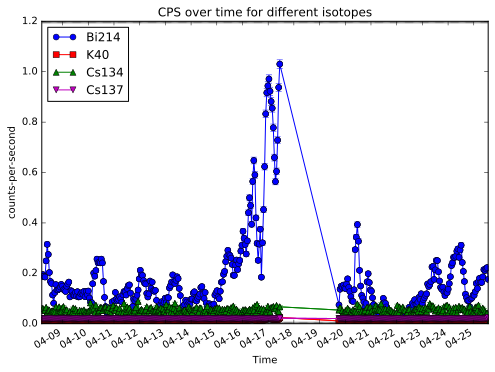

In [42]:
# graph all weather data together
fig, ax = plt.subplots()

ax.plot(date, Bi214, 'bo-', label="Bi214")
ax.errorbar(date, Bi214, yerr=np.sqrt(Bi214)/60.0, fmt='bo', ecolor='b')
ax.plot(date, K40, 'rs-', label="K40")
ax.errorbar(date, K40, yerr=np.sqrt(K40)/60.0, fmt='rs-', ecolor='r')
ax.plot(date, Cs134, 'g^-', label="Cs134")
ax.errorbar(date, Cs134, yerr=np.sqrt(Cs134)/60.0, fmt='g^-', ecolor='g')
ax.plot(date, Cs137, 'mv-', label="Cs137")
ax.errorbar(date, Cs137, yerr=np.sqrt(Cs137)/60.0, fmt='mv-', ecolor='m')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc=2)
#ax.set_yscale("log", nonposy='clip')

# format the ticks
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax.xaxis.set_minor_locator(mdates.HourLocator())

# set x-axis scale and display format
ax.set_xlim(date[0], date[-1])
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d %H:%M:%S')
# rotates and right aligns the x labels
# moves the bottom of the axes up to make room for them
fig.autofmt_xdate()

plt.ylabel('counts-per-second')
plt.xlabel('Time')
plt.title('CPS over time for different isotopes')

plt.show()

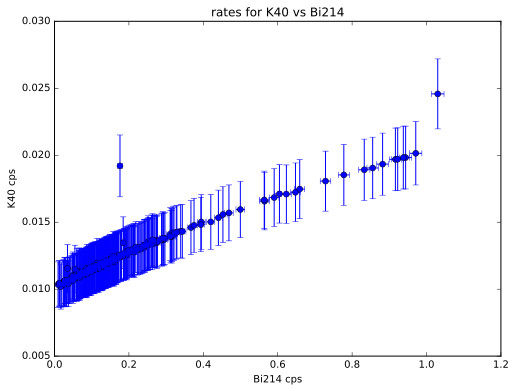

In [43]:
# plot different isotopes against eachother to see how strongly correlated they are

# here we plot Bi21 vs K40 as an example of strongly correlated data
plt.plot(Bi214,K40, 'bo')

#errors based on 1hr count collection time converted to counts-per-second
# fmt="none" stops the plot from drawing lines connecting each point
plt.errorbar(Bi214, K40, xerr=np.sqrt(Bi214)/60.0, yerr=np.sqrt(K40)/60.0, fmt="none")

plt.ylabel('K40 cps')
plt.xlabel('Bi214 cps')
plt.title('rates for K40 vs Bi214')

plt.show()

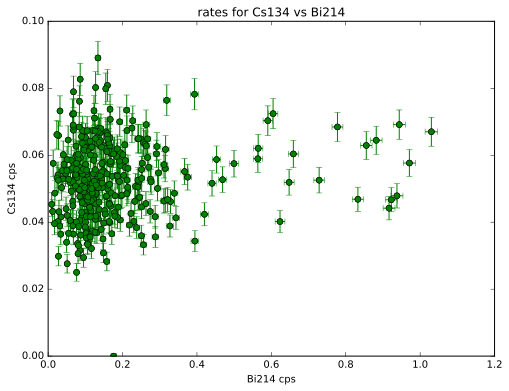

In [44]:
# here we plot Bi21 vs Cs134 as an example of uncorrelated data
plt.plot(Bi214,Cs134, 'go')

#errors based on 1hr count collection time converted to counts-per-second
# fmt="none" stops the plot from drawing lines connecting each point
plt.errorbar(Bi214, Cs134, xerr=np.sqrt(Bi214)/60.0, yerr=np.sqrt(Cs134)/60.0, fmt='go', ecolor='g')

plt.ylabel('Cs134 cps')
plt.xlabel('Bi214 cps')
plt.title('rates for Cs134 vs Bi214')

plt.show()

In [45]:
# import data froom the DoseNet roof device
Roof_Date = []
Roof_CPM = []
line = 0
url = 'https://radwatch.berkeley.edu/sites/default/files/dosenet/etch_roof.csv'
response = urllib2.urlopen(url)

reader = csv.reader(response, delimiter=",")
for row in reader:
    if line == 0:
        print ", ".join(row)
    else:
        Roof_Date.append(datetime.strptime(row[0], '%Y-%m-%d %H:%M:%S'))
        Roof_CPM.append(float(row[1]))
    line += 1

receiveTime, cpm, cpmError


In [46]:
# select DoseNet data within the same time range as the weather data
delta = timedelta(minutes=5)
min_date_index = findNearestDate(Roof_Date, date[0], delta)
max_date_index = findNearestDate(Roof_Date, date[-1], delta)
print 'found range of dates to be between', Roof_Date[min_date_index], ' and ', Roof_Date[max_date_index]

#slice out dosenet data in same range as air monitor data
Roof_sub = Roof_Date[min_date_index:(max_date_index+1)]

found range of dates to be between 2016-04-08 04:30:13  and  2016-04-25 13:30:15


In [47]:
# air monitor data is recorded every hour based on counts collected since the last recording
# DoseNet data is taken every 5 minutes
#  -> to compare the two we need to sum DoseNet data over the corresponding hour
# method returns multidimensional array with date, re-averaged CPM, error
merged_roof_data = mergeData(Roof_Date,Roof_CPM,date)
Roof_merged_date = merged_roof_data[0]
Roof_merged = merged_roof_data[1]
Roof_error = merged_roof_data[2]

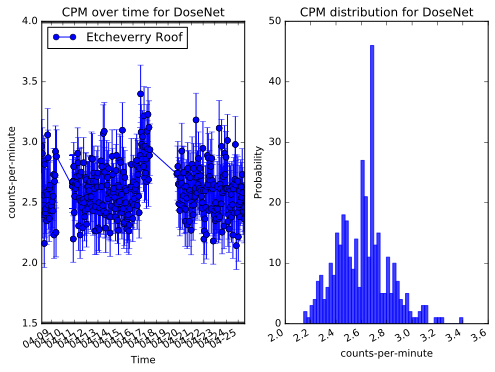

In [48]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(merged_roof_data[0], merged_roof_data[1], 'bo-', label="Etcheverry Roof")
ax1.errorbar(Roof_merged_date, Roof_merged, yerr=Roof_error, fmt='bo', ecolor='b')

#make legend
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, loc=2)

ax1.xaxis.set_major_locator(mdates.DayLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax1.xaxis.set_minor_locator(mdates.HourLocator())
ax1.set_xlim(Roof_merged_date[0], Roof_merged_date[-1])
ax1.fmt_xdata = mdates.DateFormatter('%Y-%m-%d %H:%M:%S')

# rotates and right aligns the x labels
fig.autofmt_xdate()

ax1.set_ylabel('counts-per-minute')
ax1.set_xlabel('Time')
ax1.set_title('CPM over time for DoseNet')

n, bins, patches = ax2.hist(Roof_merged, 50, facecolor='b', edgecolor='b', alpha=0.75)
ax2.set_ylabel('Probability')
ax2.set_xlabel('counts-per-minute')
ax2.set_title('CPM distribution for DoseNet')

plt.show()

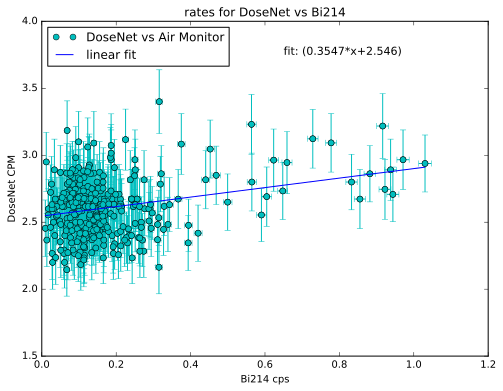

In [54]:
fig, ax = plt.subplots()

coefficients = np.polyfit(Bi214, Roof_merged, 1)
polynomial = np.poly1d(coefficients)
fit = polynomial(Bi214)

plt.plot(Bi214,Roof_merged, 'co', label="DoseNet vs Air Monitor")
plt.errorbar(Bi214, Roof_merged, xerr=np.sqrt(Bi214)/60.0, yerr=Roof_error, fmt='co', ecolor='c')

plt.ylabel('DoseNet CPM')
plt.xlabel('Bi214 cps')
plt.title('rates for DoseNet vs Bi214')

# try a linear fit to data
plt.plot(Bi214, fit, label="linear fit")

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc=2)

fit_text = ("fit: (%s*x+%s)" % ("%.4G" % coefficients[0], "%.4G" % coefficients[1]))
#get axis limits for determining text position
xlims = ax.get_xlim()
ylims = ax.get_ylim()
ax.text(xlims[0]+0.65, ylims[0]+2.25, fit_text, fontsize=11)

plt.show()

In [73]:
#returns correlation coefficient (r), and [mean,variance] for both data-sets respectively
r, stats_B, stats_R = calculateCorrelationCoefficient(Bi214,Roof_merged)
print r, stats_B, stats_R

0.283029777613 [0.1780094151091588, 0.16483560806010469] [2.608815412683995, 0.20657788874878308]


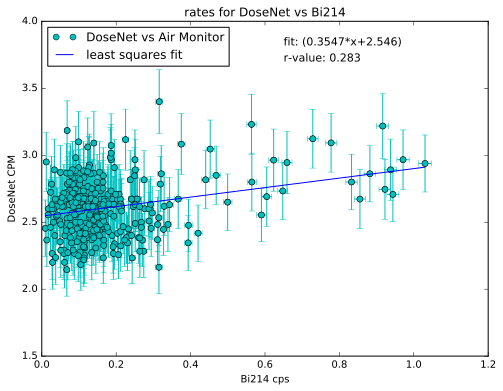

In [74]:
# try plotting with y=mx+b determined from least squares

# slope = r*var_y/var_x
slope = r*stats_R[1]/stats_B[1]
# intercept = <Y> - slope*<X>
intercept = stats_R[0] - slope*stats_B[0]

fig, ax = plt.subplots()
plt.plot(Bi214,Roof_merged, 'co', label="DoseNet vs Air Monitor")
plt.errorbar(Bi214, Roof_merged, xerr=np.sqrt(Bi214)/60.0, yerr=Roof_error, fmt='co', ecolor='c')

plt.ylabel('DoseNet CPM')
plt.xlabel('Bi214 cps')
plt.title('rates for DoseNet vs Bi214')

# draw least squares fit function
polynomial = np.poly1d([slope, intercept])
fit = polynomial(Bi214)
plt.plot(Bi214, fit, label="least squares fit")

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc=2)
fit_text = ("fit: (%s*x+%s)" % ("%.4G" % slope, "%.4G" % intercept))
r_text = ("r-value: %s" % ("%.4G" % r))

#get axis limits for determining text position
xlims = ax.get_xlim()
ylims = ax.get_ylim()
ax.text(xlims[0]+0.65, ylims[0]+2.32, fit_text, fontsize=11)
ax.text(xlims[0]+0.65, ylims[0]+2.2, r_text, fontsize=11)

plt.show()

In [75]:
# For comparison - the correlation coefficient etc. for Bi214 vs K40 from first comparison plot of air monitor data
r, stats_B, stats_K = calculateCorrelationCoefficient(Bi214,K40)
print r, stats_B, stats_K

0.971433259304 [0.1780094151091588, 0.16483560806010469] [0.012406441737581117, 0.0018461958082391643]


In [76]:
Etch_Date = []
Etch_CPM = []
line = 0
url = 'https://radwatch.berkeley.edu/sites/default/files/dosenet/etch.csv'
response = urllib2.urlopen(url)

reader = csv.reader(response, delimiter=",")
for row in reader:
    if line == 0:
        print ", ".join(row)
    else:
        Etch_Date.append(datetime.strptime(row[0], '%Y-%m-%d %H:%M:%S'))
        Etch_CPM.append(float(row[1]))
    line += 1

receiveTime, cpm, cpmError


In [77]:
# We can do the same analysis comparing the roof and hall data
merged_etch_data = mergeData(Etch_Date,Etch_CPM,date)
Etch_merged = merged_etch_data[1]
Etch_error = merged_etch_data[2]
Etch_date_merged = merged_etch_data[0]

In [78]:
#returns correlation coefficient (r), and [mean,variance] for both data-sets respectively
r, stats_E, stats_R = calculateCorrelationCoefficient(Etch_merged,Roof_merged)
print r, stats_E, stats_R

-0.027027201108 [2.4329006131498585, 0.18422328419221073] [2.608815412683995, 0.20657788874878308]


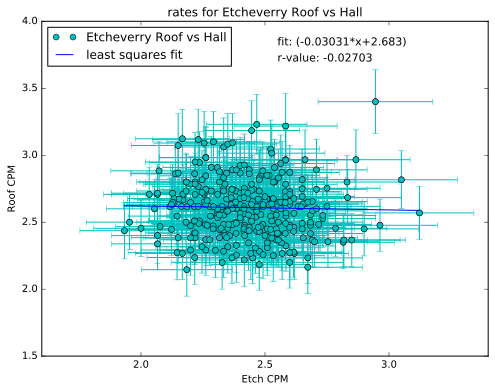

In [79]:
# try plotting with y=mx+b determined from least squares

# slope = r*var_y/var_x
slope = r*stats_R[1]/stats_E[1]
# intercept = <Y> - slope*<X>
intercept = stats_R[0] - slope*stats_E[0]

fig, ax = plt.subplots()
polynomial = np.poly1d([slope, intercept])
fit = polynomial(Etch_merged)

plt.plot(Etch_merged, Roof_merged, 'co', label="Etcheverry Roof vs Hall")
plt.errorbar(Etch_merged, Roof_merged, xerr=Etch_error, yerr=Roof_error, fmt='co', ecolor='c')

plt.plot(Etch_merged, fit, label="least squares fit")

plt.ylabel('Roof CPM')
plt.xlabel('Etch CPM')
plt.title('rates for Etcheverry Roof vs Hall')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc=2)

fit_text = ("fit: (%s*x+%s)" % ("%.4G" % slope, "%.4G" % intercept))
r_text = ("r-value: %s" % ("%.4G" % r))

#get axis limits for determining text position
xlims = ax.get_xlim()
ylims = ax.get_ylim()
ax.text(xlims[0]+0.95, ylims[0]+2.32, fit_text, fontsize=11)
ax.text(xlims[0]+0.95, ylims[0]+2.2, r_text, fontsize=11)

plt.show()